# Magnetic Field Skeleton Example
This notebook shows how to use the `synthesizAR` package to create a magnetic field extrapolation from an HMI fits file that will serve as the "skeleton" for our synthetic active region.

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('notebook',font_scale=1.5)
import astropy.units as u
from sunpy.net import vso

import synthesizAR

%matplotlib inline

## Query the VSO 
First, we need to grab an HMI fits file from the [Virtual Solar Observatory](http://sdac.virtualsolar.org/cgi/search) with [SunPy](http://sunpy.org/). We'll look at an AR from 1 January, 2013. This is the same AR that is used in [Bradshaw and Viall (2013)](http://adsabs.harvard.edu/abs/2016ApJ...821...63B).

In [2]:
client = vso.VSOClient()

In [3]:
result_hmi = client.query(
     vso.attrs.Time((2013, 1, 1, 7, 34, 0), (2013, 1, 1, 9, 0, 0)),
     vso.attrs.Instrument('HMI'),
     vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
     vso.attrs.Sample(5000 * u.s)
)

In [4]:
data_hmi = client.get(result_hmi,methods=('URL-FILE_Rice','URL-FILE')).wait()

## Set Cropping and Resampling Parameters
Next, we need to set how we'll crop and resample the map. We want to zoom in on the region-of-interest (ROI) and also downsample the map a bit so that the extrapolation won't take so long.

In [5]:
crop = (u.Quantity([-140,90]*u.arcsec),u.Quantity([420,560]*u.arcsec))

In [49]:
resample = u.Quantity([100,100]*u.pixel)

Note that both of these quantities are _units aware_. To do this, we use the [`astropy.units`](http://docs.astropy.org/en/stable/units/) module.

## The `Skeleton` object
Now we'll use the `synthesizAR.Skeleton` object to create the extrapolated field and trace the fieldlines.

In [50]:
field = synthesizAR.Skeleton(data_hmi[0],crop=crop,resample=resample)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


Before actually extrapolating the field, we need to provide some details about the $z$-direction of the field. Extrapolating the field always takes a bit.

In [51]:
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)

In [52]:
field.extrapolate_field(zshape,zrange)

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/numba/decorators.py:24: DeprecationWarning: autojit is deprecated, use jit instead which now performs the same functionality
  "the same functionality", DeprecationWarning)
yt : [INFO     ] 2016-08-30 15:33:17,109 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-08-30 15:33:17,110 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2016-08-30 15:33:17,111 Parameters: domain_left_edge          = [ -9.60112377e+09   3.00297576e+10   4.25949509e+08]
yt : [INFO     ] 2016-08-30 15:33:17,113 Parameters: domain_right_edge         = [  6.06890905e+09   3.95486152e+10   1.02227882e+10]
yt : [INFO     ] 2016-08-30 15:33:17,115 Parameters: cosmological_simulation   = 0.0


Now, we'll trace the streamlines through the 3D extrapolated field volume. Additionally, we'll also filter out any _open_ streamlines and any streamlines which are greater than 500 Mm or less than 20 Mm. We'll only do this for about 500 lines, but in principle we may want to do many more for a more complex active region.

In [53]:
field.extract_streamlines(1000)

yt : [INFO     ] 2016-08-30 15:33:31,008 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 1000/1000 [00:08<00:00, 114.74it/s]
yt : [INFO     ] 2016-08-30 15:33:41,379 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 506/506 [00:04<00:00, 118.17it/s]
yt : [INFO     ] 2016-08-30 15:33:47,058 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 269/269 [00:02<00:00, 110.55it/s]
yt : [INFO     ] 2016-08-30 15:33:50,424 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 132/132 [00:01<00:00, 107.87it/s]
yt : [INFO     ] 2016-08-30 15:33:52,311 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 69/69 [00:00<00:00, 101.55it/s]
yt : [INFO     ] 2016-08-30 15:33:53,590 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 40/40 [00:00<00:00, 102.19it/s]
yt : [INFO     ] 2016-08-30 15:33:54,553 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Str

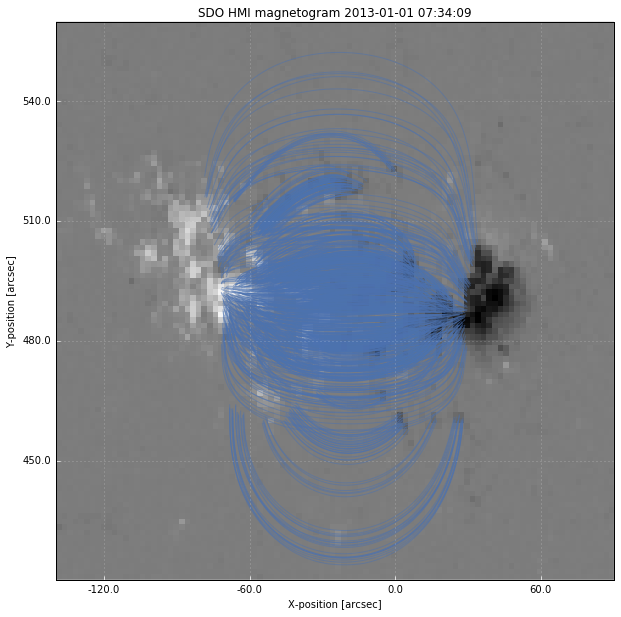

In [56]:
field.peek(alpha=0.5)

## Create Loop objects from Extrapolated Field
We want to create an easier to work with object that will hold all of the needed information about the individual loops in our active region. we'll store these objects in a list that itself is an attribute of the `field` object.

In [57]:
field.make_loops()

As an example of how we can access the data along each fieldline, we'll plot the field strength $B$ as a function of $s$, the field-aligned coordinate. Note that all of these quantities have units associated with them.

(0, 1)

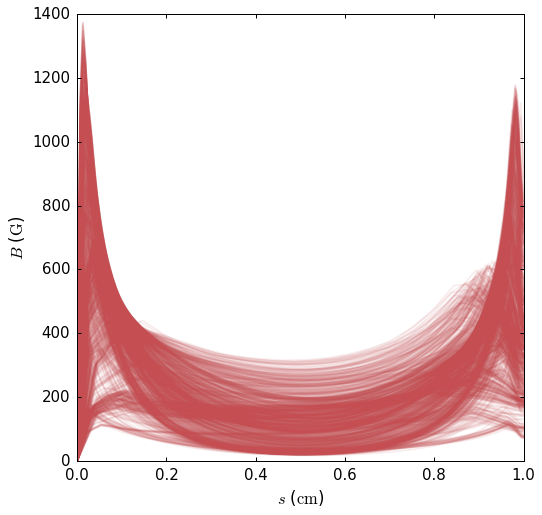

In [70]:
plt.figure(figsize=(8,8))
for loop in field.loops:
    plt.plot(loop.field_aligned_coordinate/loop.full_length,loop.field_strength,
             alpha=0.1,color=sns.color_palette('deep')[2])
plt.ylabel(r'$B$ ($\mathrm{{ {} }}$)'.format(loop.field_strength.unit.name))
plt.xlabel(r'$s$ ($\mathrm{{ {} }}$)'.format(loop.field_aligned_coordinate.unit.name))
plt.xlim([0,1])
#plt.xscale('log')
#plt.yscale('log')

Similarly, we can plot a histogram of all of the loop lengths.

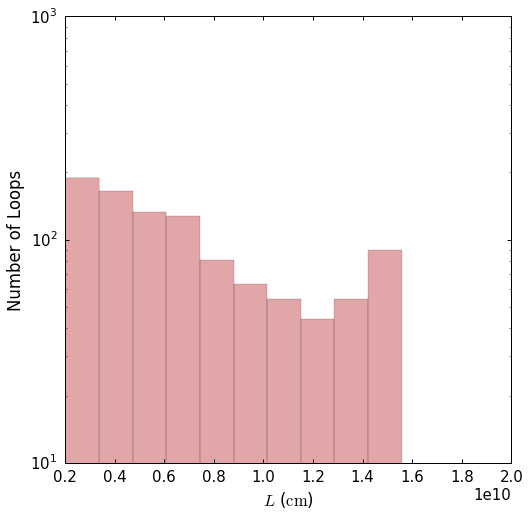

In [71]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.hist(np.array([loop.full_length.value for loop in field.loops]),
        bins=10,
        alpha=0.5,
        log=True,
        color=sns.color_palette('deep')[2]
       )
ax.set_ylabel(r'Number of Loops')
ax.set_xlabel(r'$L$ ($\mathrm{{ {} }}$)'.format(loop.full_length.unit.name))
#ax.set_xscale('log')
ax.set_xlim([2e+9,2e+10])
plt.show()